## Boundary Layer Model - V02

Kepert 2001

CONCLUSIONS: K et C jouent un rôle similaire sur l'asymétrie et l'intensité du TC. 

Ut semble ajouter une instabilité de nombre d'onde +-1 d'autant plus forte que Ut est grand. Si C est fort, cela va amplifier l'asymétrie. 

On en conclut que les zones de fortes asymétries ont un C élevé (Ut étant égal par ailleurs). On va donc pouvoir mettre un lambda élevé dans Kalashnik aux endroits où l'asymétrie est forte.

NB: L'inflow angle décroît après 2*Rmax, comme dans SM2020.

Peut-être à recouper avec le Shapiro

TODO: isoler 2 cas SAR avec la même vitesse de translation mais des asymétries différentes et en faire des conclusions sur leur Cd respectifs.

In [30]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

In [3]:
rs = np.linspace(10, 8e5, 800)
vmx = 50
rmx = 50000
B   = 2
lat = 20
K   = 50 # m2/s
Cd  = 2e-3
Ut  = 5     # Translation speed
C   = 2.5e-3 

V   = h80(rs, vmx, rmx, B, lat)
fcor= coriolis(lat)

# plt.plot(rs, v);plt.grid()

In [4]:
# Inertial stability
def I(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(r, V, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * V / r + fcor
    zeta = np.gradient(V, dr) + V / r + fcor
    return np.sqrt(ksi / zeta)

def eta(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * ((V / r) + I(r, V, fcor))))

def ki(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * I(r, V, fcor)))

def psi(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / abs(K * ((V / r) - I(r, V, fcor))))

# Amplitudes
def A0(r, V, K, C, fcor):
    num = -ki(r, V, K, C, fcor) * V * [1 + 1j * (1 + ki(r, V, K, C, fcor))]
    den = 2 * ki(r, V, K, C, fcor) ** 2 + 3 * ki(r, V, K, C, fcor) + 2
    return num / den

def A1(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * eta(r, V, K, C, fcor) + 3j * psi(r, V, K, C, fcor)]
    return num / den

def A_1(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * psi(r, V, K, C, fcor) + 3j * eta(r, V, K, C, fcor)]
    return num / den

def A1_prime(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 + 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 - 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

def A_1_prime(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 - 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 + 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(r, V, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A0(r, V, K, C, fcor)))

def v0(r, V, K, C, fcor):
    return np.squeeze(np.imag(A0(r, V, K, C, fcor)))

def u1(theta, r, V, Ut, K, C, fcor):
    u1        = V * 0
    msk       = I(r, V, fcor) >= V / r
    u1[msk]   = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    u1[~msk]  = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return u1

def v1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return v1

def u_1(theta, r, V, Ut, K, C, fcor):
    u1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    u1[msk] = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    u1[~msk]= np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return u1

def v_1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(theta, r, V, Ut, K, C, fcor):
    return u_1(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1(theta, r, V, Ut, K, C, fcor)

def v_BL(theta, r, V, Ut, K, C, fcor):
    return V + v_1(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1(theta, r, V, Ut, K, C, fcor)

In [15]:
ths     = np.linspace(0, 2 * np.pi, 361)
Rs, THs = np.meshgrid(rs, ths)
print(Rs.shape)
Us = np.ones_like(Rs)
Vs = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    # print(i, th)
    Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
    Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Xs, Ys = pol2cart(Rs, THs)

(361, 800)


0it [00:00, ?it/s]

/tmp/ipykernel_29415/3554317365.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

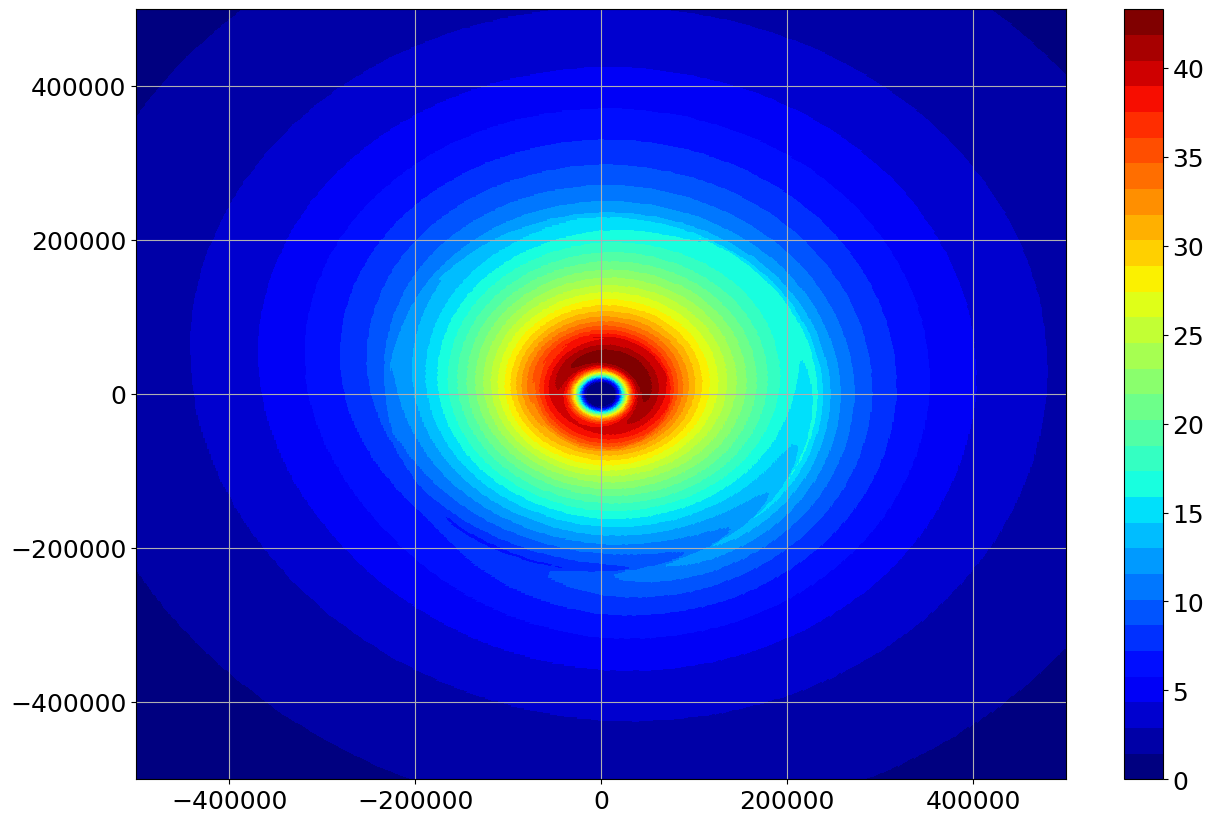

In [16]:
plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

/tmp/ipykernel_29415/4106776672.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, Vs, cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

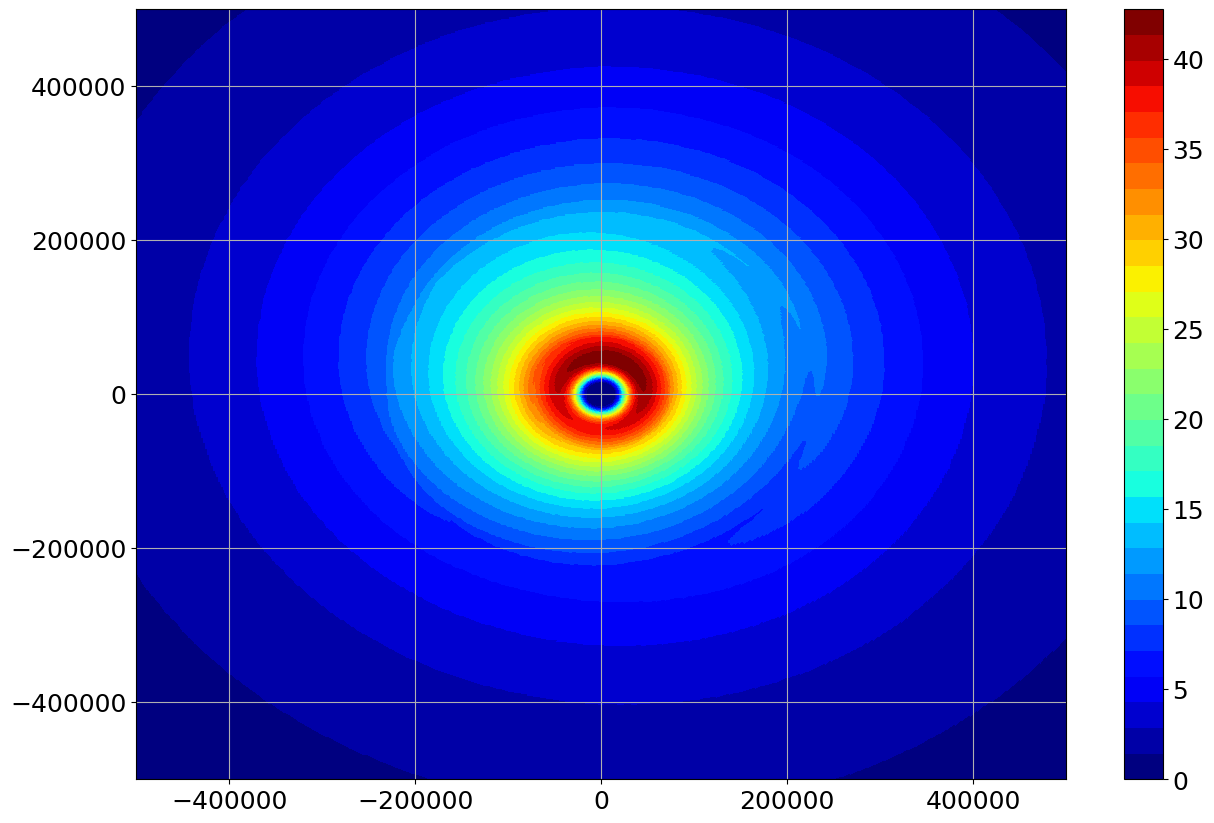

In [17]:
plt.pcolormesh(Xs, Ys, Vs, cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

/tmp/ipykernel_29415/3244345685.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, Us, cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

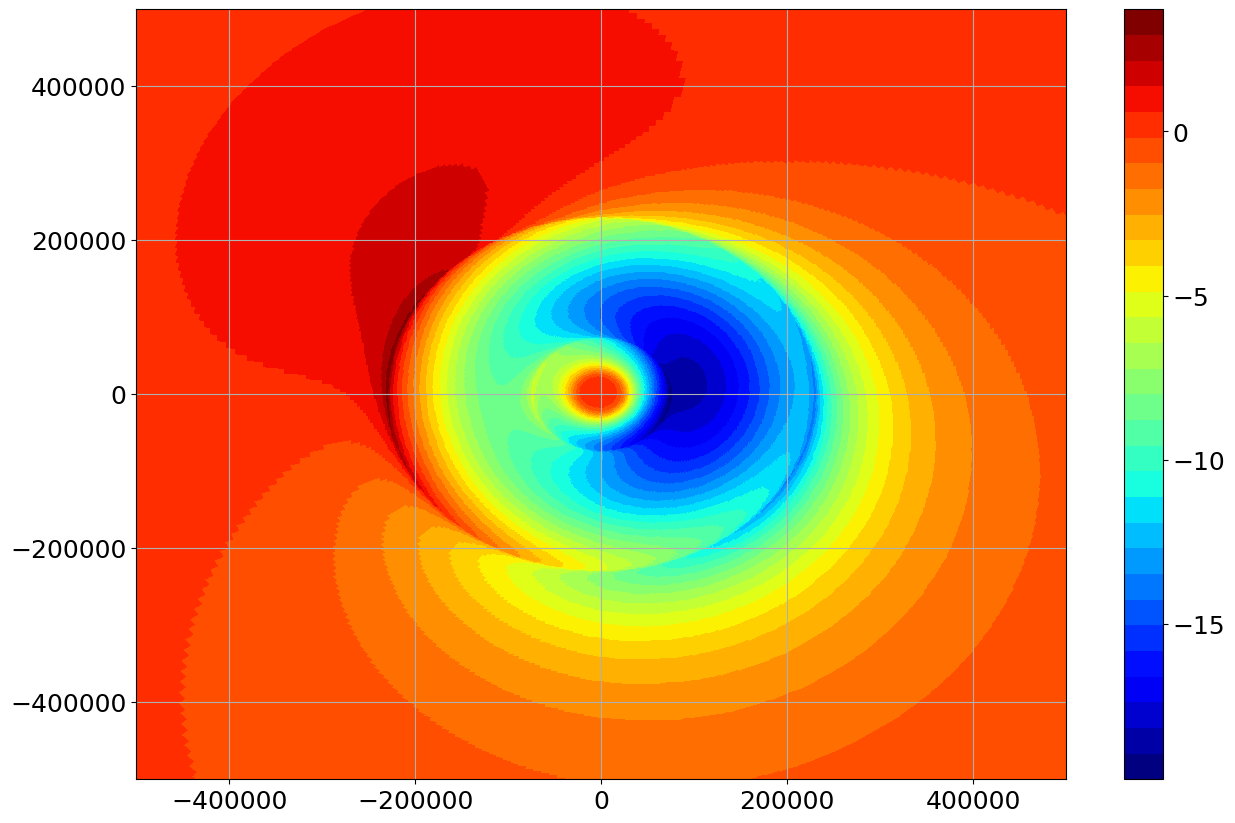

In [8]:
plt.pcolormesh(Xs, Ys, Us, cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

0it [00:00, ?it/s]

/tmp/ipykernel_29415/1755157264.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

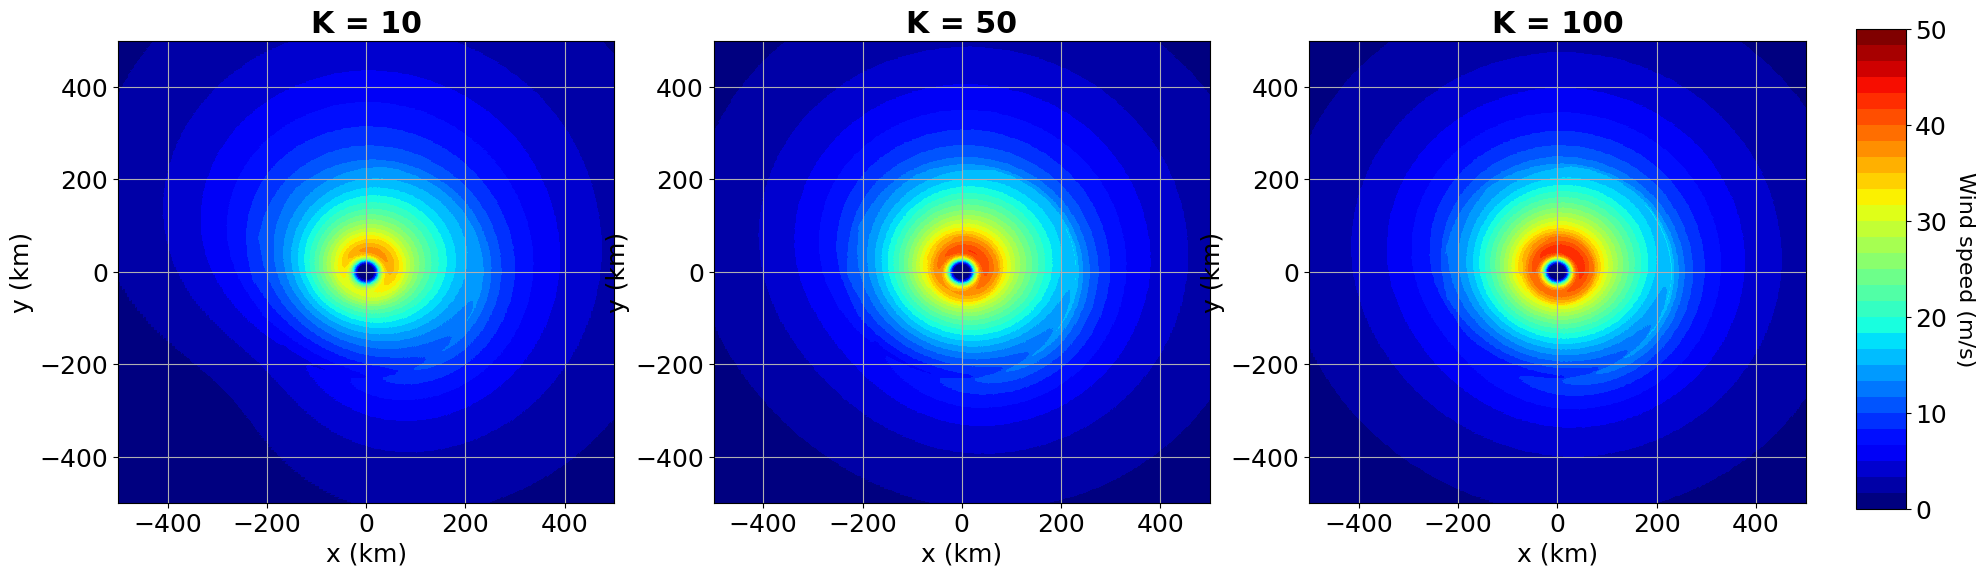

In [48]:
### VARIATIONS IN K
cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for K, ax in zip([10, 50, 100], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('K = {}'.format(K), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

0it [00:00, ?it/s]

/tmp/ipykernel_29415/3608066267.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

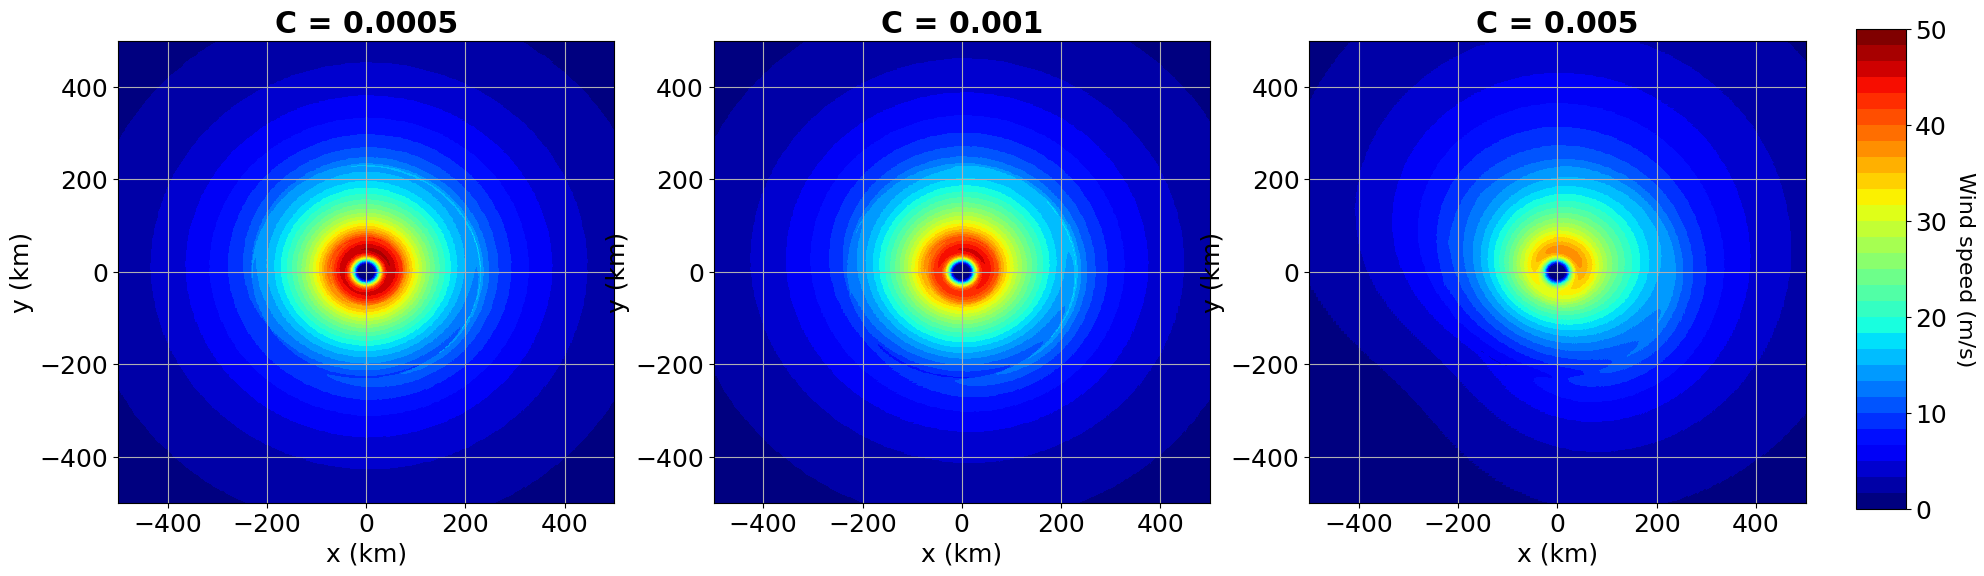

In [52]:
### VARIATIONS IN C
K = 50

cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for C, ax in zip([5e-4, 1e-3, 5e-3], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('C = {}'.format(C), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

0it [00:00, ?it/s]

/tmp/ipykernel_29415/1979699343.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

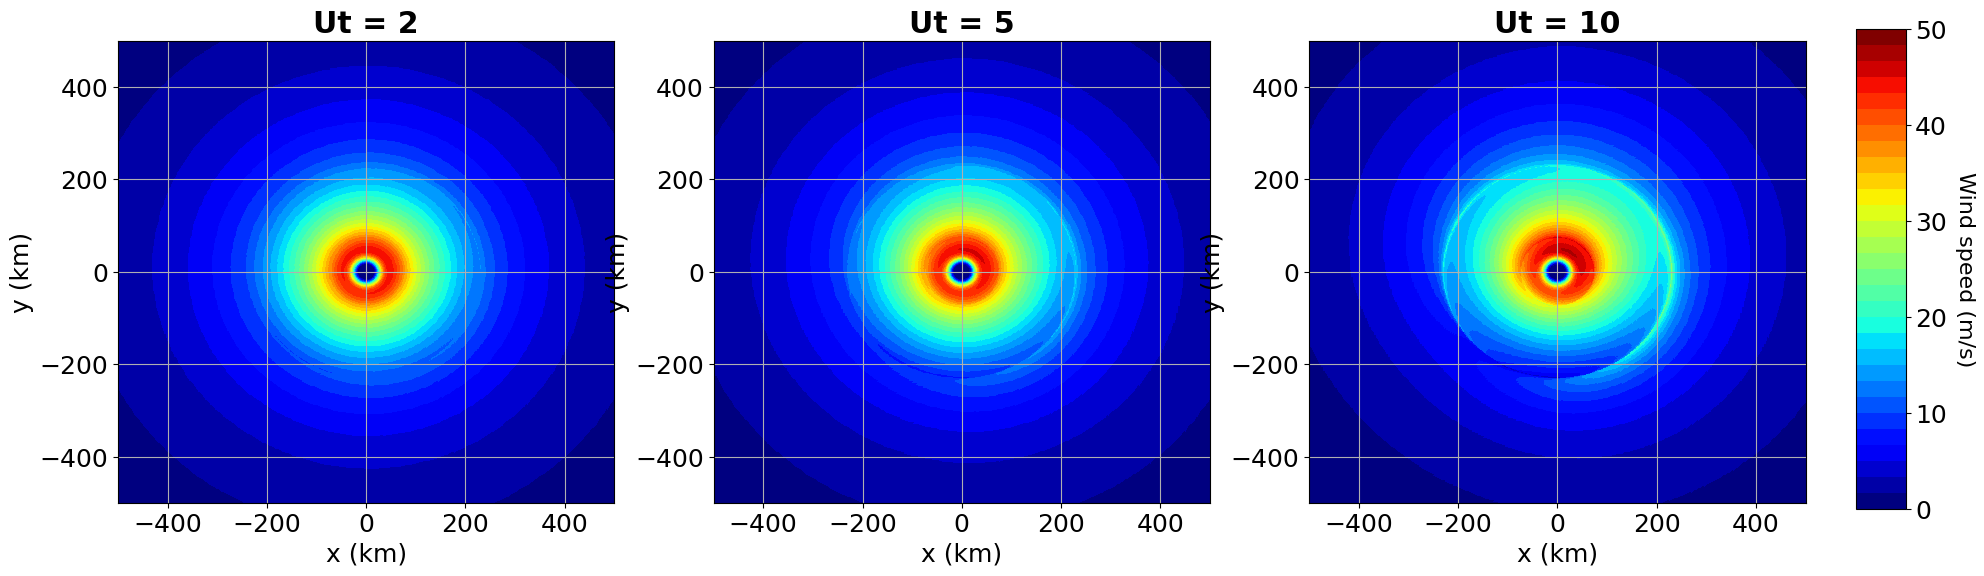

In [59]:
### VARIATIONS IN C
K = 50
C = 1e-3

cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for Ut, ax in zip([2, 5, 10], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('Ut = {}'.format(Ut), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

In [10]:
# plt.plot(u0(rs, V, K, C, fcor))
# plt.plot(V + v0(rs, V, K, C, fcor))
# plt.plot(abs(u0(rs, V, K, C, fcor) / (V + v0(rs, V, K, C, fcor))))

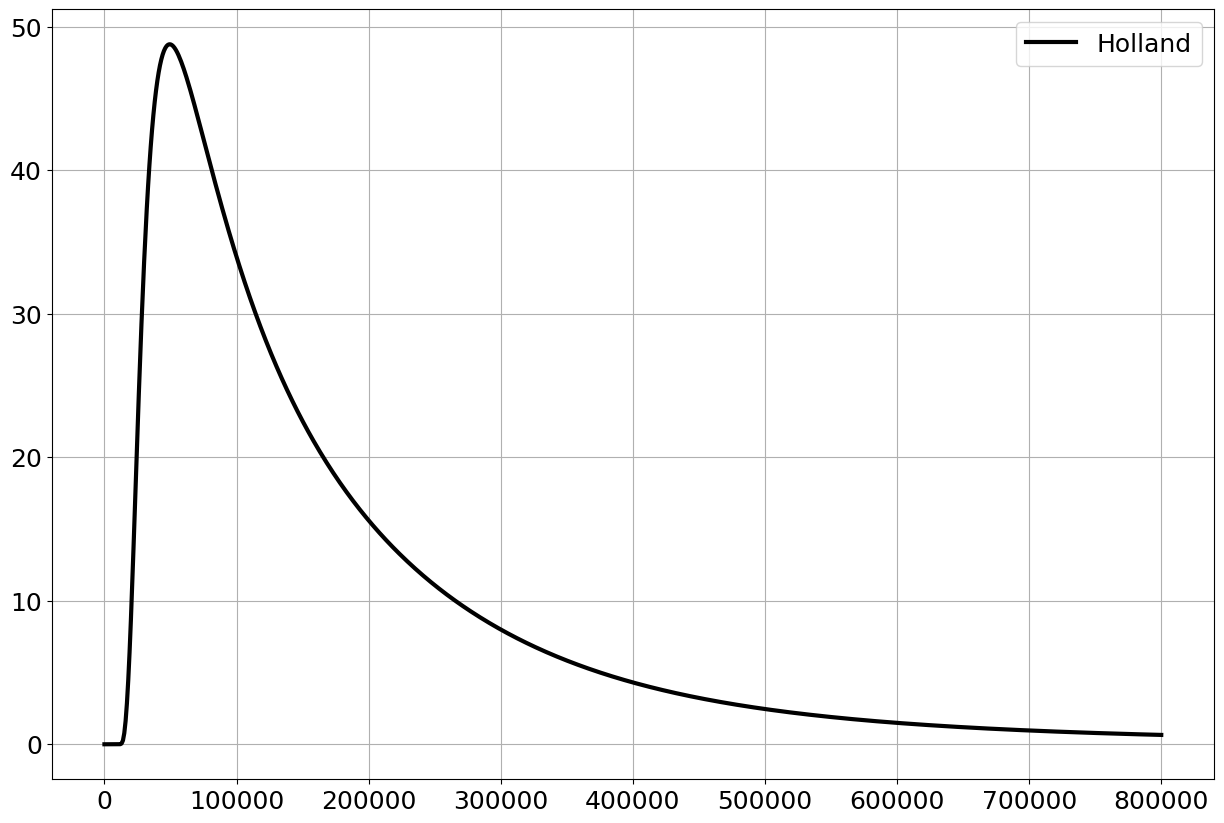

In [11]:
plt.plot(rs, V, c='k', linewidth=3, label='Holland')
# plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K), c='tab:blue', label='v BL')
# plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K2), c='tab:blue', label='v BL2', linestyle='--')
# # plt.plot(rs, v + v_prime(rs, v, fcor, Cd2, K), c='tab:blue', label='v BL2', linestyle='--')
# plt.plot(rs, -u(rs, v, fcor, Cd, K), c='tab:orange', label='-u BL')
# plt.plot(rs, 30 * (-u(rs, v, fcor, Cd, K) / (v + v_prime(rs, v, fcor, Cd, K))), c='purple', linestyle='--', label='tan a')
plt.grid();plt.legend()

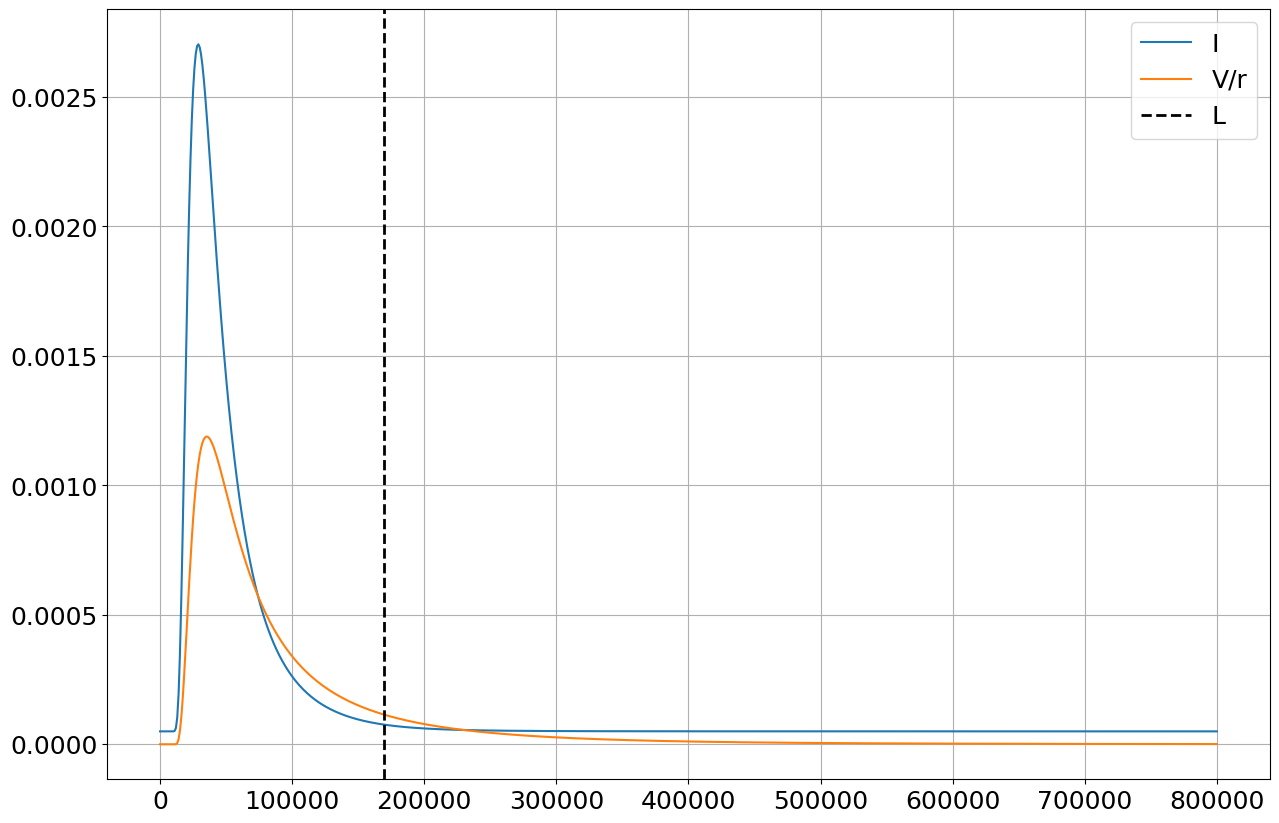

In [12]:
plt.plot(rs, I(rs, V, fcor), label='I')
plt.plot(rs, V / rs, label='V/r')

# Test
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

q        = (rs * V ** 2) / (vorticity(rs, V) + fcor)
L        = rs[np.argmax(q)] # characteristic length

plt.axvline(L, c='k', linewidth=2, label='L', linestyle='--')
plt.grid();plt.legend()

# CONCLUSION: the radius where I = V/r is exactly the characteristic length L. 
# So the asymmetric form of v_BL contains information on L!

Text(0, 0.5, 'depth (m)')

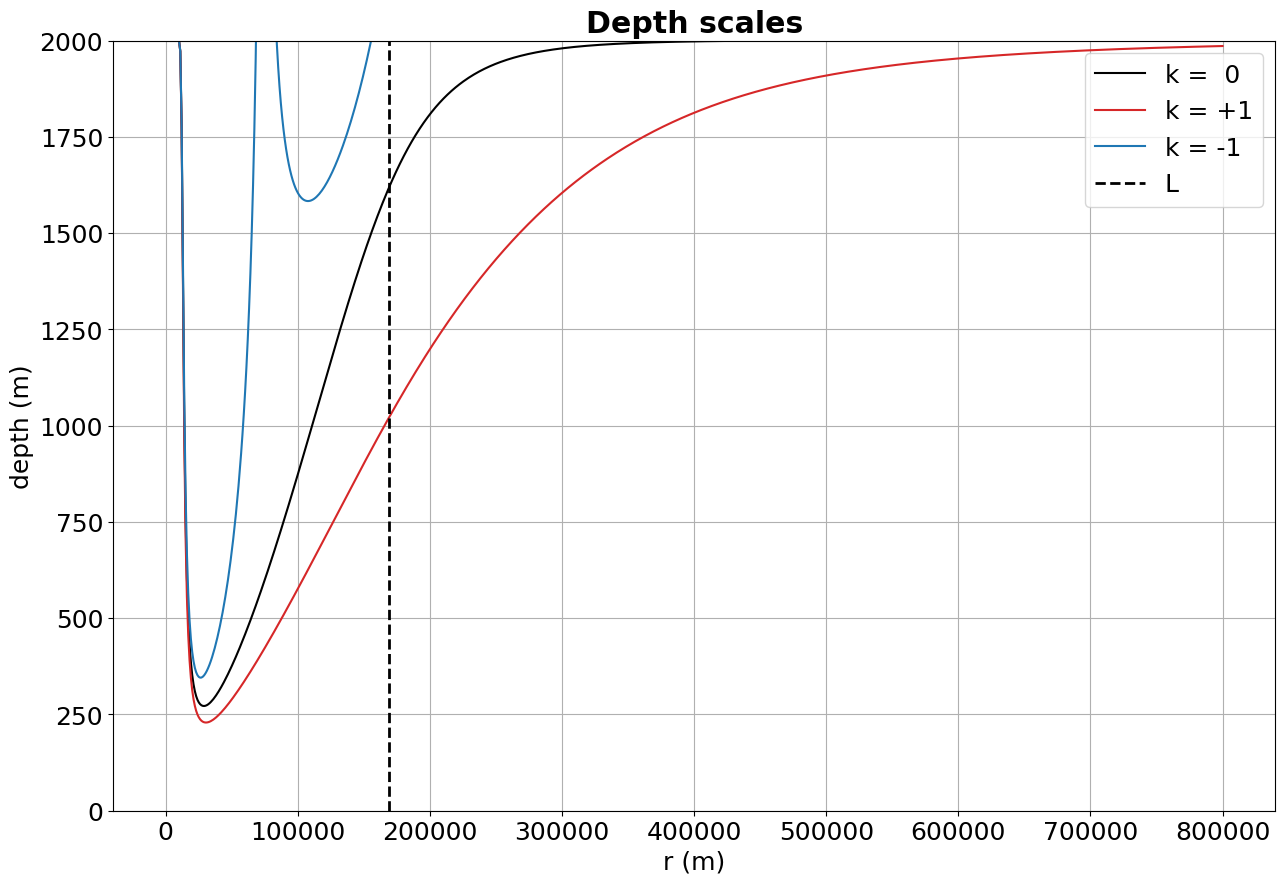

In [13]:
plt.title('Depth scales', weight='bold')
plt.plot(rs, np.sqrt( 2 * K / I(rs, V, fcor)),               label='k =  0', c='k')
plt.plot(rs, np.sqrt( 2 * K / abs(I(rs, V, fcor) + V / rs)), label='k = +1', c='tab:red')
plt.plot(rs, np.sqrt( 2 * K / abs(I(rs, V, fcor) - V / rs)), label='k = -1', c='tab:blue')
plt.axvline(L, c='k', linewidth=2, label='L', linestyle='--')
plt.ylim(0, 2000)
plt.grid();plt.legend()
plt.xlabel('r (m)');plt.ylabel('depth (m)')